**Tip:** If you get error messages running this program (e.g. by changing the country or the starting year, then choose under Kernel "Restart & run all." The Restart bit is important.

We start by loading the modules that we will need for our program. We use two different commands:

- `import module as module_name` : This loads the module `module` under the name `module_name` which
  is the name which we refer the module to. That is, to call a function from the module we will need
  to use the command `module_name.function()`.
- `from module import function` : This loads a specific function from the module. Importantly, to use
  the function in the code below we only need to call `function()`.
- Note that `module_name.function()` and `function()` perform exactly the same tasks.

The modules we will be using are the following.

- `Numpy`: This is the fundamental package/module for scientific computing in Python.
- `get_regression_coefs`: This is the .py file that contains the linear regression function of the same
name. This is to show that you can of course also create your own modules as .py files.
- `Pandas`: This is the fundamental module for data anlysis in Python. This is used for loading,
cleaning and analysing data.
- `Matplolib`: This is the fundamental module for plotting.

**Tip:** Python has excellent documentation. If you do not understand the properties of a function and
/ or are looking for other features check them online, e.g. [Numpy](https://numpy.org/doc/stable/index.html), [Pandas](https://pandas.pydata.org/docs/index.html), [Matplotlib](https://matplotlib.org/).

In [1]:
# 0) Decide whether you are up for a challenge. If yes, set ix_challenge to `True`
ix_challenge = False

In [2]:
# 1) import modules
import numpy as np # import scientific library
if ix_challenge == False:
    from get_regression_coefs import get_regression_coefs # import our function to get GDP trend
elif ix_challenge == True:
    from get_regression_coefs_incomplete import get_regression_coefs
import pandas as pd # import library for data analysis

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns # for nicer plots (not essential)
sns.set_theme('talk', style = 'white')

In [3]:
# 2.1) Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0)

In [4]:
# 2.2) Clean data

# Subset relevant columns and compute per capita real GDP
# The .loc property is used for indexing; see here for more https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html
data = data.loc[:, ("country", "year", "rgdpe", "pop")]
data["rgdpe_pc"] = data["rgdpe"] / data["pop"]

# select your country as a country
data = data.loc[data["country"] == "Belgium", ("year", "rgdpe_pc")]
# Reset the index (not crucial)
data = data.reset_index(drop = True)

# Subset the RGDP per capita series
ymax = 2006
ymin = 1950
# We use logical indexing to subset the data to rows of years ymin <= year <= ymax
Y = data.loc[np.logical_and(data["year"] <= ymax, data["year"] >= ymin), "rgdpe_pc"]
y = np.log(Y)
data = data[data["year"] >= ymin] # we keep only years after ymin

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T = len(Y) # sample size used for regression
T_all = data["year"].max() - (ymin - 1) # number of all years in the data after ymin

```# 3) Compute different trend specifications```

We will now compute four different specifications: (i) additive + linear (ii) additive + quadratic
(iii) exponential + linear and (iv) exponential + quadratic.

We will not do anything extraordinary, but simply run a linear regression. In Stata, you would run
`reg y x1 x2`. In R, you would run `lm(formula = y ~ x1 + x2, data)`. We will run
`get_regression_coefs(y, x1, x2)` in Python. The difference is that we will write this function
**ourselves**. The gain is that you will understand what's going on under the hood of your
program!!

To see what `get_regression_coefs(y, x1, x2)` does in more details see the get_regression_coefs.py
file or call `help(get_regression_coefs)`.

*(See the problem set instructions for a detailed explanations of the approach.)*

In [5]:
# 3.1) Additive Models
# 3.1.1) Additive, Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is per capita GDP in *levels*

x1 = np.empty(T) # initialise an empty vector for the first regressor
x2 = np.empty(T) # initialise an empty vector for the second regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1 # recall that Python starts indexing at 0

a_add_lin, b_add_lin = get_regression_coefs(Y, x1, x2)

Having computed the coefficients, we can now evaluate the trend for the entire time series, i.e.
also for years later than those used in the regression.

In [6]:
# Initialise predicted values yhat
Yhat_add_lin = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_lin[t] = a_add_lin + b_add_lin * (t + 1) # recall that Python indexing starts at 0

# Let us convert into log-units
yhat_add_lin = np.log(Yhat_add_lin)

In [7]:
# 3.1.2) Additive, Quadratic Model
# Let us repeat the above for a quadratic specification. Now we also need a third regressor with
# values t**2 (which is t^2 in Python)
# What will be the dependent variable for the additive model?

x1, x2, x3 = np.empty(T), np.empty(T), np.empty(T)
# same as x1 = np.empty(T); x2 = np.empty(T); x3 = np.empty(T) all in separate lines
# even more elegant: x1, x2, x3 = [np.empty(T) for j in range(3)]

# Create loop to construct vector of regressors
for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1
    x3[t] = (t + 1)**2

a_add_quad, b1_add_quad, b2_add_quad = get_regression_coefs(Y, x1, x2, x3)

# Initialise predicted values yhat
Yhat_add_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_quad[t] = a_add_quad + b1_add_quad * (t + 1) + b2_add_quad * (t + 1)**2 

# Let us convert into log-units
yhat_add_quad = np.log(Yhat_add_quad)

In [8]:
# 3.2) Exponential Model
# Independent variables are exactly as before. Which dependent variable will we use? Be careful
# about the scaling of units!

# 3.2.1) Exponential, Linear Model
x1, x2 = np.empty(T), np.empty(T) # initialise an empty vector for the first regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1 # recall that Python starts indexing at 0

a_exp_lin, b_exp_lin = get_regression_coefs(y, x1, x2)

# Initialise predicted values yhat
yhat_exp_lin = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    yhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1) # recall that Python indexing starts at 0

In [9]:
# 3.2.2) Exponential, Quadratic model
# Repeat above for quadratic specification

x1, x2, x3 = np.empty(T), np.empty(T), np.empty(T) # initialise an empty vector for the first regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1
    x3[t] = (t + 1)**2

a_exp_quad, b1_exp_quad, b2_exp_quad = get_regression_coefs(y, x1, x2, x3)

# Initialise predicted values yhat
yhat_exp_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    yhat_exp_quad[t] = a_exp_quad + b1_exp_quad * (t + 1) + b2_exp_quad * (t + 1)**2

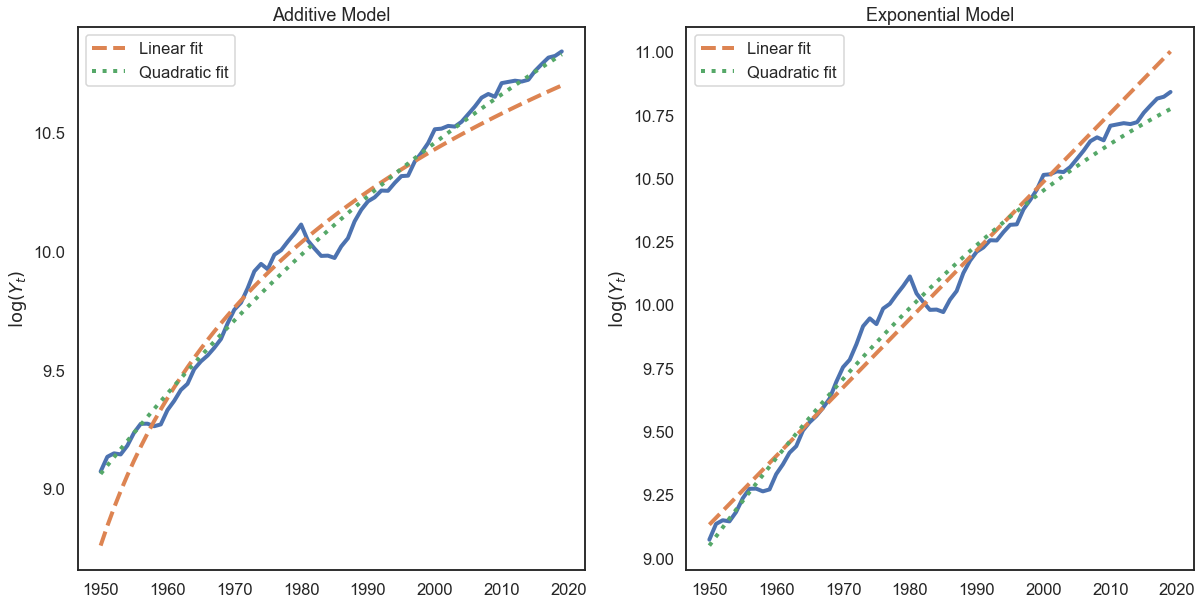

In [10]:
lw = 4

# Plot by additive and exponential
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.plot(data['year'], np.log(data['rgdpe_pc']), linewidth = lw)
ax1.plot(data['year'], yhat_add_lin, linewidth = lw, linestyle = 'dashed', label = 'Linear fit')
ax1.plot(data['year'], yhat_add_quad, linewidth = lw, linestyle = 'dotted', label = 'Quadratic fit')
ax1.set_ylabel(r'$\log(Y_t)$')
ax1.set_title('Additive Model')
ax1.legend()

ax2.plot(data['year'], np.log(data['rgdpe_pc']), linewidth = lw)
ax2.plot(data['year'], yhat_exp_lin, linewidth = lw, linestyle = 'dashed', label = 'Linear fit')
ax2.plot(data['year'], yhat_exp_quad, linewidth = lw, linestyle = 'dotted', label = 'Quadratic fit')
ax2.set_ylabel(r'$\log(Y_t)$')
ax2.set_title('Exponential Model')
ax2.legend()